# IMPORTS

In [1]:
from my_utils import tic, toc

In [2]:
start = toc()

In [152]:
from tqdm import tqdm
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import rasterio
import tensorflow as tf
import subprocess, datetime, pathlib
import csv, time
import shutil
import itertools
import pandas as pd
from pathlib import Path
import seaborn as sns

DIRECTORY CONFIG

In [4]:
# === CONFIG === ## Paths & File Extensions

IMAGE_EXT = ".tif"  # or ".png"

# INPUT DATA
TRAINING_INPUT_DIR  = "./pasadena_data_256_RGB_train_original/images"  # "TRAIN_IMAGES_ORIGINAL/images" 
CVE_INPUT_DIR  = "./pasadena_tiles_2048_32/images"   # "INFER_IMAGES_ORIGINAL/images"


#OUTPUT DATA
TRAINING_OUTPUT_DIR = "TRAIN_IMAGES_ENHANCED"  
CVE_OUTPUT_DIR = "INFER_IMAGES_ENHANCED"

INPUT_DIRS = [TRAINING_INPUT_DIR, CVE_INPUT_DIR]
OUTPUT_DIRS = [TRAINING_OUTPUT_DIR, CVE_OUTPUT_DIR]

INPUT_DIR = None
OUTPUT_DIR = None

STEALTH_MODE = 1

BASH SCRIPT EXECUTION (FOR TRAINING AND INFERENCE)

In [ ]:


# def run_pipe(mode_tag, workdir=".", script="./run_pipe.sh"):
#     ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

#     base_dir = pathlib.Path("cve_experiment_logs")
#     base_dir.mkdir(exist_ok=True)

#     # one folder per outer-loop iteration
#     run_dir = base_dir / f"{mode_tag}_{ts}"
#     run_dir.mkdir(exist_ok=True)

#     log_path = run_dir / f"{mode_tag}_{ts}.log"

#     p = subprocess.run(
#         ["bash", "-x", script],
#         cwd=workdir,
#         text=True,
#         capture_output=True
#     )

#     log_path.write_text(p.stdout + "\n\n=== STDERR ===\n" + p.stderr)

#     # OPTIONAL but recommended: copy eval metrics into run_dir
#     # adjust this path if your eval csv lives elsewhere
#     src_metrics = pathlib.Path(workdir) / "evaluation_metrics.csv"
#     if src_metrics.exists():
#         shutil.copy2(src_metrics, run_dir / "evaluation_metrics.csv")
#         shutil.copy2(src_metrics, run_dir / "evaluation_metrics.csv")

#     return p.returncode, str(log_path), str(run_dir)


In [ ]:
def run_pipe(mode_tag, workdir=".", script="./run_pipe.sh"):
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = pathlib.Path("cve_experiment_logs") / f"{mode_tag}_{ts}"
    run_dir.mkdir(parents=True, exist_ok=True)

    log_path = run_dir / "run.log"

    p = subprocess.run(
        ["bash", "-x", script],
        cwd=workdir,
        text=True,
        capture_output=True
    )

    log_path.write_text(p.stdout + "\n\n=== STDERR ===\n" + p.stderr)

    # 🔑 COPY METRICS INTO RUN DIR
    src_metrics = pathlib.Path(workdir) / "tree_point_prediction" / "cve_experiment_logs" /"evaluation_metrics.csv"
    if src_metrics.exists():
        shutil.copy(src_metrics, run_dir / "evaluation_metrics.csv")

    return p.returncode, str(log_path), str(run_dir)


LOGGING SUPPORT

In [7]:
def read_metrics_csv(path):
    """
    Reads evaluation_metrics.csv produced by run_pipe and returns a dict
    matching FIELDNAMES metric keys.
    """
    out = {}
    with open(path, "r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            m = row["Metric"].strip()
            v = row["Value"].strip()

            if m == "True Positives (TP)":
                out["tp"] = int(v)
            elif m == "False Negatives (FN)":
                out["fn"] = int(v)
            elif m == "False Positives (FP)":
                out["fp"] = int(v)
            elif m == "Precision":
                out["precision"] = float(v)
            elif m == "Recall":
                out["recall"] = float(v)
            elif m == "F1 Score":
                out["f1"] = float(v)
            elif m == "Average Distance for Matches":
                out["avg_dist_match"] = float(v.replace(" meters",""))
            elif m == "Average Distance to Closest Predicted Tree":
                out["avg_dist_closest"] = float(v.replace(" meters",""))

    return out

In [8]:
FIELDNAMES = [
    "stamp","grid_id",
    "alpha","sigma","low_perc","high_perc","gamma",
    "True Positives (TP)","False Negatives (FN)","False Positives (FP)",
    "Precision","Recall","F1 Score",
    "Average Distance for Matches","Average Distance to Closest Predicted Tree"
]

def append_summary(run_dir, grid_id, params, metrics):
    summary_csv = os.path.join(run_dir, "cve_run_summary.csv")
    write_header = not os.path.exists(summary_csv)

    row = {
        "stamp": time.strftime("%Y%m%dT%H%M%SZ", time.gmtime()),
        "grid_id": grid_id,
        "alpha": params["alpha"],
        "sigma": params["sigma"],
        "low_perc": params["low_perc"],
        "high_perc": params["high_perc"],
        "gamma": params["gamma"],
        **{k: metrics.get(k, "") for k in FIELDNAMES if k in metrics}
    }

    with open(summary_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=FIELDNAMES)
        if write_header:
            w.writeheader()
        w.writerow(row)


# CV ENHANCEMENT MAIN

#### FINAL ENHANCEMENT - RUN THIS SECTION TO ENHANCE WITH IDEAL VALUES GATHERED IN THE RANDOM GRID SEARCH SECTION  BELOW
#### CVE FUNCTION SCOPED VARIABLES BELOW ARE CONSIDERED A GOOD BASELINE, TREAD CAREFULLY.

In [9]:
# # ✅ CRASH RECOVERY CELL # 1: Selective Enhancement Resume via Filename Diff
# # ACTIVATE THE LINE IN THE NEXT CELL WITH --> "for in_path in tqdm(recovery_paths", RUN FROM THERE DOWN
#
# # Define source and destination directories
# source_dir = INPUT_DIR      # raw input chips
# dest_dir   = OUTPUT_DIR   # enhanced outputs
#
# # Get list of .tif filenames (not paths)
# source_files = {f for f in os.listdir(source_dir) if f.endswith(".tif")}
# dest_files   = {f for f in os.listdir(dest_dir)   if f.endswith(".tif")}
#
# # Compute set difference: which source images are not yet enhanced
# recovery_files = sorted(list(source_files - dest_files))
# print(f"{len(recovery_files)} images will be recovered")

# VISUALIZATION SUPPORT

In [10]:
def is_image_different(path1, path2, mode="path"):
    img1 = None
    img2 = None

    if mode == "path":
        img1 = cv2.imread(str(path1))
        img2 = cv2.imread(str(path2))

    if mode == "chip":
        img1 = cv2.imread(str(path1))
        img2 = tf.cast(tf.squeeze(path2), tf.uint8).numpy()
        img2 = img2.astype(np.uint8)
        if STEALTH_MODE: 
            print(type(img1), type(img2))
    return not np.array_equal(img1, img2)

In [11]:
def pick_chip(mode="static", static_path=None, chip_dir=None):
    """Returns chip path based on selection mode: static or random."""
    if mode == "static":
        assert static_path is not None, "Static path required for mode='static'"
        assert static_path is not None, "Static path required for mode='static'"
        return static_path
    elif mode == "random":
        assert chip_dir is not None, "chip_dir required for mode='random'"
        files = [f for f in os.listdir(chip_dir) if f.lower().endswith(IMAGE_EXT)]
        return os.path.join(chip_dir, random.choice(files))
    else:
        raise ValueError("mode must be 'static' or 'random'")

In [12]:
image_diff = []
def show_random_chip_comparisons(diff_flag=1, comparison_size=2):

    all_files = [f for f in os.listdir(OUTPUT_DIR) if f.lower().endswith(IMAGE_EXT)]
    random.shuffle(all_files)  # 💥 Restore randomness

    for file_name in tqdm(all_files[:comparison_size]):
        orig_path = os.path.join(INPUT_DIR, file_name)
        corr_path = os.path.join(OUTPUT_DIR, file_name)

        if diff_flag == 1:
            image_diff.append(is_image_different(orig_path, corr_path))

        orig = cv2.cvtColor(cv2.imread(str(orig_path)), cv2.COLOR_BGR2RGB)
        corr = cv2.cvtColor(cv2.imread(str(corr_path)), cv2.COLOR_BGR2RGB)

        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        axs[0].imshow(orig)
        axs[0].set_title(f"Original: {file_name}")
        axs[1].imshow(corr)
        axs[1].set_title("Corrected")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    return image_diff

In [13]:
NUM_COMPARES = 3
show_random_chip_comparisons(comparison_size=NUM_COMPARES)
if STEALTH_MODE:
    print(image_diff)
image_diff.clear()

0it [00:00, ?it/s]

[]


# THE RANDOM GRID SEARCH SECTION

FULL RANDOM GRID SEARCH - TO FIND "ENHANCEMENT FUNCTION SCOPE" VARIABLE VALUES THAT IMPACT IMAGE QUALITY
EVEN THOUGH THIS SECTION IS MEANT FOR BROAD EXPLORATION, YOU CAN DO DELICATE WORK HERE TOO

In [14]:
## ACTUAL GRID SEARCH
# === TRANSFORM FUNCTIONS WITH PARAMS AS ARGUMENTS ===
# === IMAGE TRANSFORMATION FUNCTIONS ===
def apply_sharpening(img, alpha=10.04, aa_sigma=3.20):
    """Applies hybrid sharpening to a uint8 RGB image in [0, 255]."""
    img = img.astype(np.float32)

    # Predefined 5×5 Gaussian low-pass kernel
    discrete_g = np.array([
        [0.002969, 0.013306, 0.021938, 0.013306, 0.002969],
        [0.013306, 0.059634, 0.098320, 0.059634, 0.013306],
        [0.021938, 0.098320, 0.162103, 0.098320, 0.021938],
        [0.013306, 0.059634, 0.098320, 0.059634, 0.013306],
        [0.002969, 0.013306, 0.021938, 0.013306, 0.002969],
    ], dtype=np.float32)

    blur = cv2.filter2D(img, -1, discrete_g)
    mask = img - blur
    sharpened = cv2.GaussianBlur(img + alpha * mask, (3, 3), sigmaX=aa_sigma)

    return np.clip(sharpened, 0, 255).astype(np.uint8)


def apply_contrast(img, low_perc=2, high_perc=98):
    """Stretches contrast by remapping low/high percentiles to [0, 255]."""
    img = img.astype(np.float32)
    p_low = np.percentile(img, low_perc)
    p_high = np.percentile(img, high_perc)

    stretched = (img - p_low) / (p_high - p_low + 1e-5)
    stretched = np.clip(stretched, 0, 1)
    return (stretched * 255).astype(np.uint8)


def apply_brightness(img, gamma=1.1):
    """Adjusts brightness using gamma correction (γ > 1 = brighter)."""
    img = img.astype(np.float32) / 255.0
    corrected = np.power(img, 1 / gamma)
    return (np.clip(corrected, 0, 1) * 255).astype(np.uint8)


def apply_centering(img):
    # Placeholder – returns image as-is
    return img

# === TUNING GRID SEARCH FUNCTION ===
def cv_tuning_grid_search(img_path,
                          alphaz=np.linspace(1.35, 1.45, 5),
                          aa_sigmas=np.linspace(1.85, 1.95, 5),
                          low_percs = np.linspace(1, 3, 5),
                          high_percs = np.linspace(97, 99, 5),
                          gammas = np.linspace(1.0, 1.2, 5),
                          grid_shape=(2, 2), foo=4):

    img_raw = cv2.imread(img_path)
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    # Build grid combos
    grid = list(itertools.product(alphaz, aa_sigmas, low_percs, high_percs, gammas))
    random.shuffle(grid)  # Optional
    n_combos = len(grid)
    n_rows, n_cols = grid_shape

    # This section supports a gentle transition from generating grids of single images with varied transforms to grids of varied images with a single set of transforms applied
    if n_rows * n_cols > n_combos:
        if STEALTH_MODE:
            print("[!] Not enough parameter combos for the requested grid layout.")
            print(f"    Requested: {n_rows*n_cols}, Available combos: {n_combos}")

        # FALLBACK: Random Image Grid using Final Parameters
        final_params = {
            "alpha": 1.25,
            "aa_sigma": 1.5,
            "low_perc": 3.0,
            "high_perc": 97.25,
            "gamma": 0.9,
        }

        image_files = [
            os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR)
            if f.lower().endswith(('.tif', '.tiff', '.png', '.jpeg', '.jpg'))
        ]
        selected_images = random.sample(image_files, n_rows * n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        axes = axes.flatten()

        for idx, img_file in enumerate(selected_images):
            img_raw = cv2.imread(img_file)
            img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

            # Apply final params
            # img = apply_sharpening(img, final_params["alpha"], final_params["aa_sigma"])
            img = apply_contrast(img, final_params["low_perc"], final_params["high_perc"])
            img = apply_brightness(img, final_params["gamma"])

            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"{os.path.basename(img_file)}", fontsize=8)

        plt.suptitle(f"Final Param Random Grid\nα:{final_params['alpha']} | "
                     f"σ:{final_params['aa_sigma']} | "
                     f"C:{final_params['low_perc']}–{final_params['high_perc']} | "
                     f"Γ:{final_params['gamma']}", fontsize=14)
        plt.tight_layout()
        plt.show()
        return

    base_size = 1  # baseline scaling factor
    min_size = foo# minimum figure width/height
    figsize = (max(base_size * n_cols, min_size), max(base_size * n_rows, min_size))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axs = axes.flatten()

    for idx, (alpha, sigma, low_perc, high_perc, gamma) in enumerate(grid[:n_rows * n_cols]):
        # Store schedule
        params = {
            "grid_id": idx,
            "alpha": float(alpha),
            "sigma": float(sigma),
            "low_perc": float(low_perc),
            "high_perc": float(high_perc),
            "gamma": float(gamma),
            "tag": f"G{idx:02d}"
        }

        img = img_raw.copy()
        img = apply_sharpening(img, alpha=alpha, aa_sigma=sigma)
        img = apply_contrast(img, low_perc=low_perc, high_perc=high_perc)
        img = apply_brightness(img, gamma=gamma)

        axs[idx].imshow(img, interpolation='none')
        axs[idx].axis('off')
        axs[idx].set_title(f" Alpha:{alpha:.3f}| AA-Sigma:{sigma:.3f}  | C:low-{low_perc:.3f} high-{high_perc:.3f}| Gamma:{gamma:.3f}", fontsize=8)

    plt.suptitle(f"CV Enhancement Results: sample = {os.path.basename(img_path)}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [15]:
# === TUNING GRID SEARCH FUNCTION ===
def cv_tuning_single_image(img_path, custom_min=4.5):
    # Read and convert the image
    img_raw = cv2.imread(img_path)
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    # Final fixed parameter example
    final_params = {
        "alpha": 1.25,
        "aa_sigma": 1.5,
        "low_perc": 3.0,
        "high_perc": 97.25,
        "gamma": 0.9,
    }

    # Apply transformations
    img = img_raw.copy()
    # img = apply_sharpening(img, final_params["alpha"], final_params["aa_sigma"])
    img = apply_contrast(img, final_params["low_perc"], final_params["high_perc"])
    img = apply_brightness(img, final_params["gamma"])

    # Create a figure
    figsize = (custom_min, custom_min)
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the resulting image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"{os.path.basename(img_path)}\nα:{final_params['alpha']}/σ:{final_params['aa_sigma']} | "
        f"C:{final_params['low_perc']}/{final_params['high_perc']} | Γ:{final_params['gamma']}",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

# ENHANCEMENT CONFIG

In [16]:

def linspace_band(start, stop, steps, pad_frac=0.25):
    """Return (low_band, mid_band, high_band) arrays."""
    span = (stop - start)
    pad = span * pad_frac
    mid = np.linspace(start, stop, steps)
    low = np.linspace(start - pad, start, max(2, steps//2))
    high = np.linspace(stop, stop + pad, max(2, steps//2))
    return low, mid, high

def median_val(arr):
    arr = list(arr)
    return arr[len(arr)//2]


In [17]:

def build_cve_schedule(ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS,
                       add_mixed=0, seed=30):
    """
    Returns a list[dict] with keys:
    alpha, sigma, low_perc, high_perc, gamma
    """
    random.seed(seed)

    # center values
    c = {
        "alpha": median_val(ALPHAS),
        "sigma": median_val(AAS),
        "low_perc": median_val(LOW_PERCS),
        "high_perc": median_val(HIGH_PERCS),
        "gamma": median_val(GAMMAS),
    }

    schedule = []

    # 1) LOCAL GRID (3x3 => 9): sample pairs across alpha/sigma, keep others center
    # (cheap + meaningful; you can swap which two params you grid)
    a3 = [ALPHAS[0], median_val(ALPHAS), ALPHAS[-1]]
    s3 = [AAS[0], median_val(AAS), AAS[-1]]
    for a in a3:
        for s in s3:
            schedule.append({**c, "alpha": float(a), "sigma": float(s)})

    # 2) PROBES (low/high one at a time)
    probes = [
        ("alpha", ALPHAS[0]), ("alpha", ALPHAS[-1]),
        ("sigma", AAS[0]), ("sigma", AAS[-1]),
        ("low_perc", LOW_PERCS[0]), ("low_perc", LOW_PERCS[-1]),
        ("high_perc", HIGH_PERCS[0]), ("high_perc", HIGH_PERCS[-1]),
        ("gamma", GAMMAS[0]), ("gamma", GAMMAS[-1]),
    ]
    for k, v in probes:
        schedule.append({**c, k: float(v)})

    # 3) OPTIONAL MIXED (interaction coverage) — random draws from full refined ranges
    for _ in range(add_mixed):
        schedule.append({
            "alpha": float(random.choice(list(ALPHAS))),
            "sigma": float(random.choice(list(AAS))),
            "low_perc": float(random.choice(list(LOW_PERCS))),
            "high_perc": float(random.choice(list(HIGH_PERCS))),
            "gamma": float(random.choice(list(GAMMAS))),
        })

    return schedule


In [18]:
def build_cve_schedule_random(
    ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS,
    n_combos=50, seed=42
):
    random.seed(seed)
    schedule = []
    for i in range(n_combos):
        schedule.append({
            "alpha": random.choice(ALPHAS),
            "sigma": random.choice(AAS),
            "low_perc": random.choice(LOW_PERCS),
            "high_perc": random.choice(HIGH_PERCS),
            "gamma": random.choice(GAMMAS),
        })
    return schedule


In [19]:

def build_cve_schedule_stratified(
    ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS,
    n_combos=50, seed=42
):
    random.seed(seed)

    full_grid = list(itertools.product(
        ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS
    ))

    random.shuffle(full_grid)
    picked = full_grid[:n_combos]

    schedule = []
    for a, s, lp, hp, g in picked:
        schedule.append({
            "alpha": a,
            "sigma": s,
            "low_perc": lp,
            "high_perc": hp,
            "gamma": g,
        })
    return schedule


In [20]:
# ImageTuning
# === Parameter Ranges (Final Refined Bracket) ===
ALPHA_START = 0.01  # Lower end for subtle sharpening
ALPHA_STOP = 0.1  # Upper end for slightly stronger sharpening
ALPHA_STEPS = 5

AAS_START = 0.25    # Lower end for Anti Alias Sigma
AAS_STOP = 0.75     # Upper end for slightly stronger smoothing
AAS_STEPS = 5

LOW_PERC_START = 2.75
LOW_PERC_STOP = 3.25
LOW_PERC_STEPS = 3

HIGH_PERC_START = 94.75
HIGH_PERC_STOP = 96.25
HIGH_PERC_STEPS = 3

GAMMA_START = 0.875    # Narrowed range for Gamma
GAMMA_STOP = 0.925     # Slightly brighter or darker range
GAMMA_STEPS = 3

# === Final Linspaces for Grid Search ===
ALPHAS = np.linspace(ALPHA_START, ALPHA_STOP, ALPHA_STEPS)
AAS = np.linspace(AAS_START, AAS_STOP, AAS_STEPS)
GAMMAS = np.linspace(GAMMA_START, GAMMA_STOP, GAMMA_STEPS)
LOW_PERCS = np.linspace(LOW_PERC_START, LOW_PERC_STOP, LOW_PERC_STEPS)
HIGH_PERCS = np.linspace(HIGH_PERC_START, HIGH_PERC_STOP, HIGH_PERC_STEPS)

ALPHAS = np.linspace(ALPHA_START, ALPHA_STOP, ALPHA_STEPS)
AAS = np.linspace(AAS_START, AAS_STOP, AAS_STEPS)
GAMMAS = np.linspace(GAMMA_START, GAMMA_STOP, GAMMA_STEPS)
LOW_PERCS = np.linspace(LOW_PERC_START, LOW_PERC_STOP, LOW_PERC_STEPS)
HIGH_PERCS = np.linspace(HIGH_PERC_START, HIGH_PERC_STOP, HIGH_PERC_STEPS)

PICK A SAMPLE TO USE TO SHOW THE ENHANCEMENT RESULTS; RANDOM SELECT or FIXED TARGET
DISPLAY A SINGLE SAMPLE

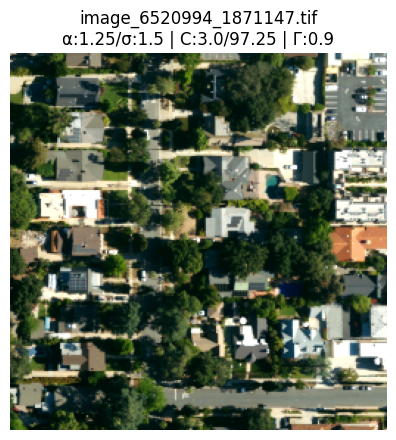

In [21]:
img_path = pick_chip(
    mode="random",  # or "static" <---just comment out his line
    static_path="/pasadena_data_256_RGB_train_original/images/bishop_2020_0.tif",  
    chip_dir=TRAINING_INPUT_DIR   #supports random sample selection
)

for x in range(1):
    cv_tuning_single_image(
        img_path=img_path,
    )

In [22]:
CVE_schedules = []

In [23]:
CVE_schedule_refined = build_cve_schedule(ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS, add_mixed=9, seed=30)   # 0 or 9
print("Refined combos:", len(CVE_schedule_refined))
print(CVE_schedule_refined[:2])
CVE_schedules.append(CVE_schedule_refined)


Refined combos: 28
[{'alpha': 0.01, 'sigma': 0.25, 'low_perc': 3.0, 'high_perc': 95.5, 'gamma': 0.9}, {'alpha': 0.01, 'sigma': 0.5, 'low_perc': 3.0, 'high_perc': 95.5, 'gamma': 0.9}]


In [24]:
CVE_schedule_random = build_cve_schedule_random(
    ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS,
    n_combos=11
)
print("Random combos:", len(CVE_schedule_random))
print(CVE_schedule_random[:2])
CVE_schedules.append(CVE_schedule_random)

Random combos: 11
[{'alpha': 0.01, 'sigma': 0.25, 'low_perc': 3.25, 'high_perc': 95.5, 'gamma': 0.875}, {'alpha': 0.0325, 'sigma': 0.375, 'low_perc': 3.25, 'high_perc': 94.75, 'gamma': 0.925}]


In [25]:
CVE_schedule_stratified = build_cve_schedule_stratified(
    ALPHAS, AAS, LOW_PERCS, HIGH_PERCS, GAMMAS,
    n_combos=11
)
print("Stratified combos:", len(CVE_schedule_stratified))
print(CVE_schedule_stratified[:2])
CVE_schedules.append(CVE_schedule_stratified)

Stratified combos: 11
[{'alpha': 0.0775, 'sigma': 0.375, 'low_perc': 3.0, 'high_perc': 94.75, 'gamma': 0.875}, {'alpha': 0.01, 'sigma': 0.375, 'low_perc': 3.0, 'high_perc': 95.5, 'gamma': 0.875}]


# THE BIG SHOW

In [26]:
'''
PART 2  --- ENHANCEMENT/TRAINING/INFERENCE ---
'''
for sched_id, CVE_schedule in enumerate(CVE_schedules, start=1):
    print(f"=== Schedule {sched_id}/{len(CVE_schedules)} ===")

    for grid_id, params in enumerate(CVE_schedule, start=1):
    # for grid_id, params in enumerate(CVE_schedule):
        # enhance → train/infer
        # LOAD THE COMBOS
        ALPHA = params["alpha"]
        SIGMA = params["sigma"]
        LOW_PERC = params["low_perc"]
        HIGH_PERC = params["high_perc"]
        GAMMA = params["gamma"]
        # STAGE 1 --- ENHANCE ---
        for in_dir, out_dir in zip(INPUT_DIRS, OUTPUT_DIRS):

            INPUT_DIR = in_dir
            OUTPUT_DIR = out_dir
            os.makedirs(OUTPUT_DIR, exist_ok=True)

            for filename in tqdm(os.listdir(INPUT_DIR)):
                if not filename.lower().endswith(IMAGE_EXT):
                    continue

                in_path = os.path.join(INPUT_DIR, filename)
                out_path = os.path.join(OUTPUT_DIR, filename)

                with rasterio.open(in_path) as src:
                    array = src.read()
                    array = np.transpose(array, (1, 2, 0))

                    array = apply_sharpening(array, alpha=ALPHA, aa_sigma=SIGMA)
                    array = apply_contrast(array, low_perc=LOW_PERC, high_perc=HIGH_PERC)
                    array = apply_brightness(array, gamma=GAMMA)

                    processed_array = np.transpose(array, (2, 0, 1))
                    meta = src.meta.copy()
                    meta["dtype"] = processed_array.dtype

                    with rasterio.open(out_path, "w", **meta) as dst:
                        dst.write(processed_array)
        # STAGE 2 TRAINING/INFERENCE
        mode_tag = f"G{grid_id:02d}_EE"
        rc, log, run_dir = run_pipe(mode_tag=mode_tag)   # <- adjust run_pipe to return run_dir
        if rc != 0:
            print("FAIL:", log)
            break

        metrics = read_metrics_csv("./pasadena_tiles_2048_32_finetuned1/evaluation_metrics.csv")
        append_summary(run_dir, grid_id, params, metrics)


=== Schedule 1/3 ===


100%|██████████| 130/130 [00:38<00:00,  3.34it/s]


=== Schedule 2/3 ===


100%|██████████| 130/130 [00:39<00:00,  3.31it/s]


=== Schedule 3/3 ===


100%|██████████| 130/130 [00:42<00:00,  3.06it/s]


# ARE WE STILL HOT

In [153]:
if CVE_schedule_refined:print("STILL HOT!")

STILL HOT!


In [35]:
foo = ["a"]

In [36]:
if foo:print("goo")

goo


## DISPLAY A SGRID OF ENHANCED SAMPLE S

In [27]:
# '''
# PART 1 --- RANDOM GRID SEARCH EXECUTION --- 
# '''
# grid_size = 2 # any square-friendly value # try to stay 2 - 4, else things get a little sluggish 
# N_TRIALS  = 1 # Each trial will produce (grid_size**2) combinations
# for x in range(N_TRIALS): ## <--- YOU CAN STACK STACK SOME GRIDS IF YOU WANT...DONT GET TOO  CRAZY...1 for 1 grid
#     cv_tuning_grid_search(
#         img_path=img_path,
#         alphaz=ALPHAS,
#         aa_sigmas=AAS,
#         low_percs = LOW_PERCS,
#         high_percs = HIGH_PERCS,
#         gammas = GAMMAS,
#         grid_shape=(grid_size, grid_size),
#         foo=14
#     )

## DISPLAY A SINGLE ENHANCED SAMPLE 

In [28]:
# ## REFERENCE OUTPUT ABOVE
# ref_img = cv2.imread(img_path)
# ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(5, 5))
# plt.imshow(ref_img)
# plt.title("Raw Reference Chip")
# plt.axis("off")
# plt.show()

# # SINGLE SAMPLE OUTPUT ---
# for x in range(1):
#     cv_tuning_single_image(
#         img_path=img_path
#     )

In [29]:
print(f"Train Runtime: {(toc() - start)/60:0.2f} minutes.")

Train Runtime: 527.98 minutes.


In [52]:
import pandas as pd
last_log = "cve_experiment_logs/G09_EE_20260114_083242/cve_run_summary.csv"
cve_df = pd.read_csv(last_log)
cve_df

,stamp,grid_id,alpha,sigma,low_perc,high_perc,gamma,True Positives (TP),False Negatives (FN),False Positives (FP),Precision,Recall,F1 Score,Average Distance for Matches,Average Distance to Closest Predicted Tree
0,20260114T164245Z,9,0.01,0.25,3.0,94.75,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
metrics_log = "metrics_log.csv"
metrics_df = pd.read_csv(metrics_log)
metrics_df.head(-1)

,20251127T110013Z,eval,eval.1,1,True Positives (TP),47093
0,20251127T110013Z,eval,eval,1,False Negatives (FN),9977
1,20251127T110013Z,eval,eval,1,False Positives (FP),191742
2,20251127T110013Z,eval,eval,1,Precision,0.1972
3,20251127T110013Z,eval,eval,1,Recall,0.8252
4,20251127T110013Z,eval,eval,1,F1 Score,0.3183
...,...,...,...,...,...,...
529,20260114T185243Z,train,15,1,False Positives (FP),198989
530,20260114T185243Z,train,15,1,Precision,0.1828
531,20260114T185243Z,train,15,1,Recall,0.7799
532,20260114T185243Z,train,15,1,F1 Score,0.2962


AGGREGATE CVE SCHEDULE RESULTS

In [60]:

ROOT = Path("cve_experiment_logs")  # run from tree_point_prediction/
EXCLUDE_PREFIX = "G00_EE_20260113_"  # legacy logs (files, not dirs)

# 1) find all per-run summaries we want
summary_paths = []
for p in ROOT.glob("G*_EE_*/cve_run_summary.csv"):
    # p looks like: cve_experiment_logs/G02_EE_20260114_021626/cve_run_summary.csv
    run_dir = p.parent.name
    if "_20260114_" not in run_dir:
        continue

    if run_dir.startswith(EXCLUDE_PREFIX):
        continue
    summary_paths.append(p)

print("Found summaries:", len(summary_paths))

# 2) stack into one DF
dfs = []
for p in sorted(summary_paths):
    df = pd.read_csv(p)
    df["run_dir"] = p.parent.name           # keep provenance
    df["run_path"] = str(p.parent.resolve())
    dfs.append(df)

cve_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# 3) quick sanity
print("Rows:", len(cve_df), "Cols:", len(cve_df.columns))
cve_df.head()


Found summaries: 50
Rows: 50 Cols: 17


,stamp,grid_id,alpha,sigma,low_perc,high_perc,gamma,True Positives (TP),False Negatives (FN),False Positives (FP),Precision,Recall,F1 Score,Average Distance for Matches,Average Distance to Closest Predicted Tree,run_dir,run_path
0,20260114T102547Z,1,0.0100,0.250,3.00,95.50,0.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01_EE_20260114_021554,/home/madmango2829/madmango_projects/GC_releas...
1,20260114T151707Z,1,0.0100,0.250,3.25,95.50,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01_EE_20260114_070746,/home/madmango2829/madmango_projects/GC_releas...
2,20260114T171519Z,1,0.0775,0.375,3.00,94.75,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01_EE_20260114_090534,/home/madmango2829/madmango_projects/GC_releas...
3,20260114T103630Z,2,0.0100,0.500,3.00,95.50,0.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G02_EE_20260114_022656,/home/madmango2829/madmango_projects/GC_releas...
4,20260114T152725Z,2,0.0325,0.375,3.25,94.75,0.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G02_EE_20260114_071816,/home/madmango2829/madmango_projects/GC_releas...


JOIN CVE SCHEDULE RESULTS WITH COORESPONDING TRAINING METRICS

In [137]:
# --- load metrics_log.csv (no header) ---
m = pd.read_csv("metrics_log.csv", header=None,
                names=["stamp","phase","runish","k","metric","value"])

# robust timestamp parse (handles missing Z / different formats)
m["stamp_dt"] = pd.to_datetime(m["stamp"], errors="coerce", utc=True)
# if your CVE stamps are naive, drop tz:
m["stamp_dt"] = m["stamp_dt"].dt.tz_convert(None)

# --- pivot to one row per metrics stamp ---
mv = (m
      .pivot_table(index=["stamp_dt"], columns="metric", values="value", aggfunc="last")
      .reset_index()
)

# --- CVE stamps ---
cve = cve_df.copy()
cve["stamp_dt"] = pd.to_datetime(cve["stamp"], errors="coerce", utc=True).dt.tz_convert(None)

# --- asof join: CVE → next metrics stamp after it ---
joined = pd.merge_asof(
    cve.sort_values("stamp_dt"),
    mv.sort_values("stamp_dt"),
    left_on="stamp_dt",
    right_on="stamp_dt",
    direction="forward",
    tolerance=pd.Timedelta("20m")   # widen if needed
)
joined = joined.loc[:, ~joined.columns.str.endswith("_x")] # cut unwated
joined.columns = (
    joined.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[()]", "", regex=True)
)

print("CVE time range:", cve["stamp_dt"].min(), "→", cve["stamp_dt"].max())
print("MET time range:", mv["stamp_dt"].min(), "→", mv["stamp_dt"].max())
print("MET stamp_dt NaT %:", mv["stamp_dt"].isna().mean())

rename_map = {
    "stamp_dt": "run_datetime",

    "True Positives (TP)_y": "true_positives",
    "False Negatives (FN)_y": "false_negatives",
    "False Positives (FP)_y": "false_positives",

    "Precision_y": "precision",
    "Recall_y": "recall",
    "F1 Score_y": "f1_score",

    "Average Distance for Matches_y": "average_distance_for_matches",
    "Average Distance to Closest Predicted Tree_y":
        "average_distance_to_closest_predicted_tree",
}

joined_clean = joined.rename(columns=rename_map)
joined_clean = joined_clean.rename(columns={c: c[:-2] for c in joined_clean.columns if c.endswith("_y")})
joined_clean.head()



CVE time range: 2026-01-14 10:25:47 → 2026-01-14 19:02:20
MET time range: 2025-11-27 11:00:13 → 2026-01-14 18:52:43
MET stamp_dt NaT %: 0.0


,stamp,grid_id,alpha,sigma,low_perc,high_perc,gamma,run_dir,run_path,run_datetime,average_distance_for_matches,average_distance_to_closest_predicted_tree,f1_score,false_negatives_fn,false_positives_fp,precision,recall,true_positives_tp
0,20260114T102547Z,1,0.010,0.25,3.0,95.5,0.9,G01_EE_20260114_021554,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:25:47,4.68 meters,4.83 meters,0.2334,8149,313148,0.1351,0.8572,48921
1,20260114T103630Z,2,0.010,0.50,3.0,95.5,0.9,G02_EE_20260114_022656,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:36:30,4.98 meters,5.26 meters,0.2614,10801,250607,0.1559,0.8107,46269
2,20260114T104702Z,3,0.010,0.75,3.0,95.5,0.9,G03_EE_20260114_023739,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:47:02,5.12 meters,6.24 meters,0.2913,15177,188630,0.1817,0.7341,41893
3,20260114T105723Z,4,0.055,0.25,3.0,95.5,0.9,G04_EE_20260114_024811,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:57:23,5.03 meters,5.45 meters,0.2773,11946,223275,0.1681,0.7907,45124
4,20260114T110750Z,5,0.055,0.50,3.0,95.5,0.9,G05_EE_20260114_025827,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 11:07:50,5.26 meters,5.58 meters,0.2603,11411,248156,0.1554,0.8001,45659


In [138]:
joined_clean.shape

(50, 18)

In [147]:
joined_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   stamp                                       50 non-null     object        
 1   grid_id                                     50 non-null     int64         
 2   alpha                                       50 non-null     float64       
 3   sigma                                       50 non-null     float64       
 4   low_perc                                    50 non-null     float64       
 5   high_perc                                   50 non-null     float64       
 6   gamma                                       50 non-null     float64       
 7   run_dir                                     50 non-null     object        
 8   run_path                                    50 non-null     object        
 9   run_datetime

In [148]:
import pandas as pd
import numpy as np

# starting point: joined (your merged df)
joined_clean = joined.loc[:, ~joined.columns.str.endswith("_x")].copy()
joined_clean = joined_clean.rename(columns={c: c[:-2] for c in joined_clean.columns if c.endswith("_y")})

# --- 1) rename distance cols to make units explicit (optional but I like it) ---
rename_units = {
    "average_distance_for_matches": "average_distance_for_matches_m",
    "average_distance_to_closest_predicted_tree": "average_distance_to_closest_predicted_tree_m",
}
joined_clean = joined_clean.rename(columns={k:v for k,v in rename_units.items() if k in joined_clean.columns})

# --- 2) coerce numeric columns (single source of truth) ---
numeric_cols = [
    "alpha","sigma","gamma","low_perc","high_perc",
    "precision","recall","f1_score",
    "true_positives_tp","false_negatives_fn","false_positives_fp",
    "average_distance_for_matches_m",
    "average_distance_to_closest_predicted_tree_m",
]
for c in numeric_cols:
    if c in joined_clean.columns:
        # handle "X meters" and plain numerics
        s = joined_clean[c].astype(str).str.replace(" meters", "", regex=False).str.strip()
        joined_clean[c] = pd.to_numeric(s, errors="coerce")

# --- 3) optional: enforce datetime dtype ---
if "run_datetime" in joined_clean.columns:
    joined_clean["run_datetime"] = pd.to_datetime(joined_clean["run_datetime"], errors="coerce")

# sanity check
joined_clean[numeric_cols].dtypes



alpha                                           float64
sigma                                           float64
gamma                                           float64
low_perc                                        float64
high_perc                                       float64
precision                                       float64
recall                                          float64
f1_score                                        float64
true_positives_tp                               float64
false_negatives_fn                              float64
false_positives_fp                              float64
average_distance_for_matches_m                  float64
average_distance_to_closest_predicted_tree_m    float64
dtype: object

In [150]:
joined_clean.head()

,stamp,grid_id,alpha,sigma,low_perc,high_perc,gamma,run_dir,run_path,stamp_dt,average_distance_for_matches_m,average_distance_to_closest_predicted_tree_m,f1_score,false_negatives_fn,false_positives_fp,precision,recall,true_positives_tp
0,20260114T102547Z,1,0.010,0.25,3.0,95.5,0.9,G01_EE_20260114_021554,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:25:47,4.68,4.83,0.2334,8149.0,313148.0,0.1351,0.8572,48921.0
1,20260114T103630Z,2,0.010,0.50,3.0,95.5,0.9,G02_EE_20260114_022656,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:36:30,4.98,5.26,0.2614,10801.0,250607.0,0.1559,0.8107,46269.0
2,20260114T104702Z,3,0.010,0.75,3.0,95.5,0.9,G03_EE_20260114_023739,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:47:02,5.12,6.24,0.2913,15177.0,188630.0,0.1817,0.7341,41893.0
3,20260114T105723Z,4,0.055,0.25,3.0,95.5,0.9,G04_EE_20260114_024811,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 10:57:23,5.03,5.45,0.2773,11946.0,223275.0,0.1681,0.7907,45124.0
4,20260114T110750Z,5,0.055,0.50,3.0,95.5,0.9,G05_EE_20260114_025827,/home/madmango2829/madmango_projects/GC_releas...,2026-01-14 11:07:50,5.26,5.58,0.2603,11411.0,248156.0,0.1554,0.8001,45659.0


In [ ]:
df = joined_clean.copy()

# --- 0) ensure the columns we care about exist (adapt if your names differ) ---
params = ["alpha", "sigma", "gamma", "low_perc", "high_perc"]
metric_cols = ["recall", "precision", "f1_score"]
dist_cols = ["average_distance_for_matches", "average_distance_to_closest_predicted_tree"]

# --- 1) coerce numeric columns (fixes your min/max crash) ---
for c in params + metric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# distances sometimes come as "5.03 meters"
for c in dist_cols:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)
                 .str.replace(" meters", "", regex=False)
                 .str.strip()
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- 2) drop rows that can't plot ---
df_plot = df.dropna(subset=["recall"] + [p for p in params if p in df.columns]).copy()

# --- 3) plot: Recall vs key CVE params ---
ymin, ymax = df_plot["recall"].min(), df_plot["recall"].max()

fig, axes = plt.subplots(
    1, len(params),
    figsize=(4 * len(params), 3),
    sharey=True,
    constrained_layout=True
)

# if only one param (edge case), axes isn't iterable
if len(params) == 1:
    axes = [axes]

for ax, p in zip(axes, params):
    sns.scatterplot(data=df_plot, x=p, y="recall", ax=ax, s=35, alpha=0.8)
    sns.regplot(data=df_plot, x=p, y="recall", ax=ax, scatter=False, lowess=True, line_kws={"linewidth": 2})
    ax.set_title(f"Recall vs {p}")
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.25)

plt.show()

# --- 4) Top recall runs table (works after coercion) ---
cols = [
    "grid_id",
    "alpha","sigma","low_perc","high_perc","gamma",
    "recall","precision","f1_score",
    "true_positives_tp","false_negatives_fn","false_positives_fp",
    "average_distance_for_matches",
    "average_distance_to_closest_predicted_tree",
    "run_datetime","run_dir"
]
cols = [c for c in cols if c in df.columns]  # avoid KeyError if names differ

top_runs = (
    df.sort_values(["recall", "f1_score"], ascending=False)[cols].head(12)
)

top_runs

## TRAINING PERFORMANCE vs IAMGE QUALITY

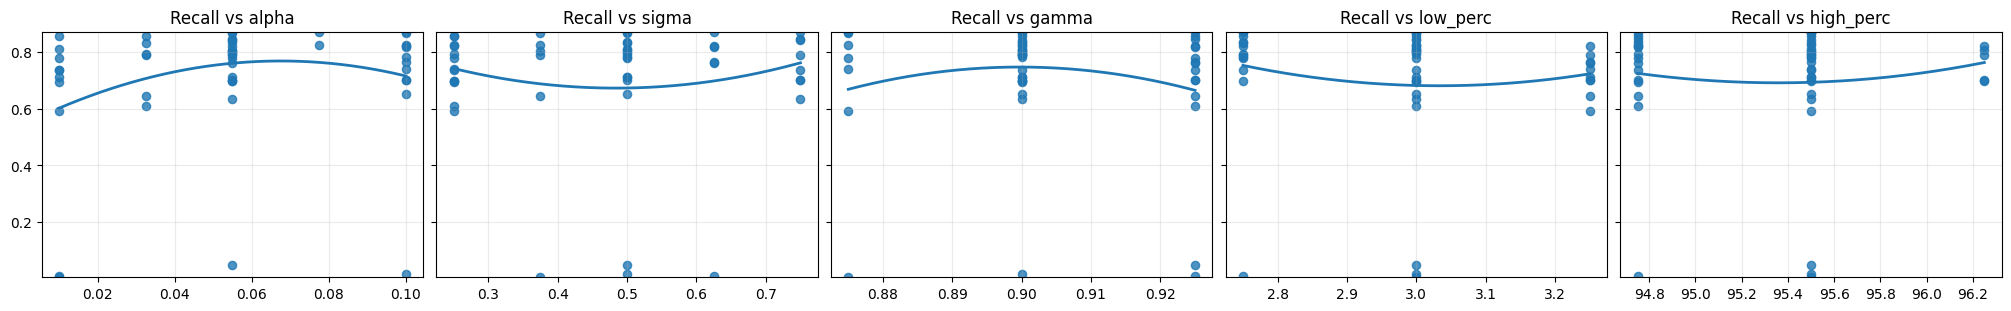

In [ ]:


df = joined_clean.copy()

params = ["alpha", "sigma", "gamma", "low_perc", "high_perc"]

df_plot = df.dropna(subset=["recall"] + params)

ymin, ymax = df_plot["recall"].min(), df_plot["recall"].max()

fig, axes = plt.subplots(
    1, len(params),
    figsize=(4 * len(params), 3),
    sharey=True,
    constrained_layout=True
)

if len(params) == 1:
    axes = [axes]

for ax, p in zip(axes, params):
    x = df_plot[p].values
    y = df_plot["recall"].values

    # scatter
    ax.scatter(x, y, s=35, alpha=0.8)

    # smooth curve via polynomial fit
    xs = np.linspace(x.min(), x.max(), 200)
    coeffs = np.polyfit(x, y, deg=2)   # deg=1 if you want linear
    ys = np.polyval(coeffs, xs)

    ax.plot(xs, ys, linewidth=2)

    ax.set_title(f"Recall vs {p}")
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.25)

plt.show()



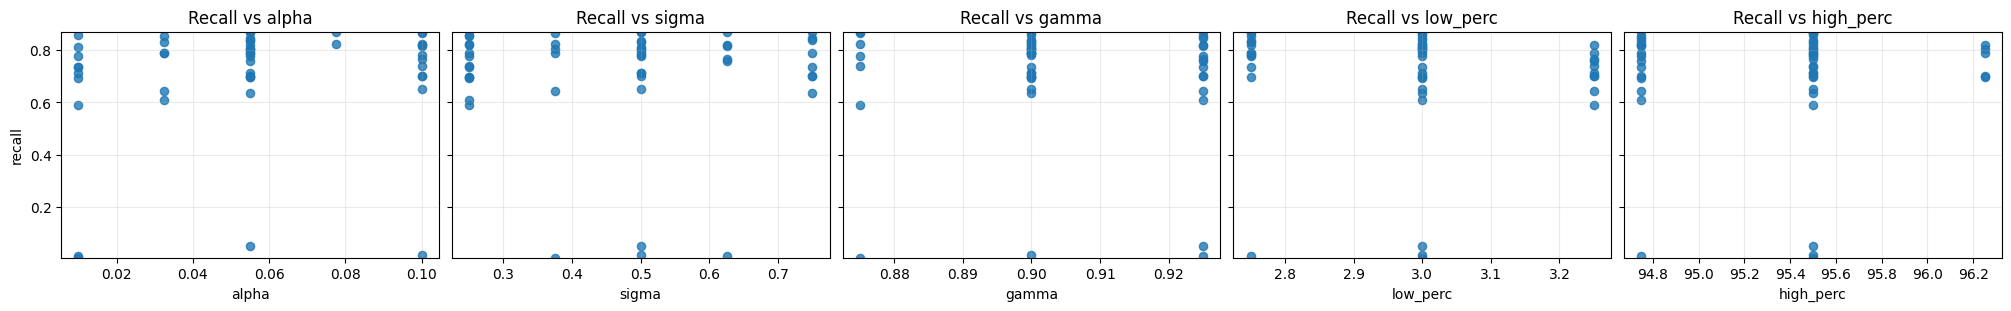

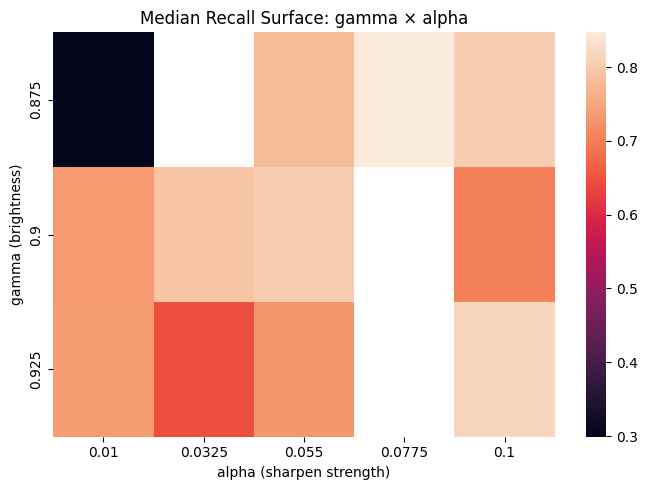

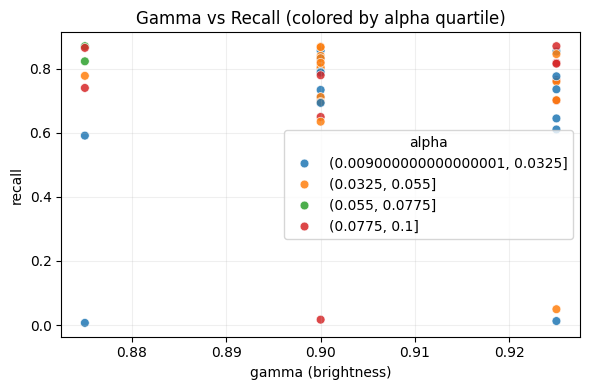

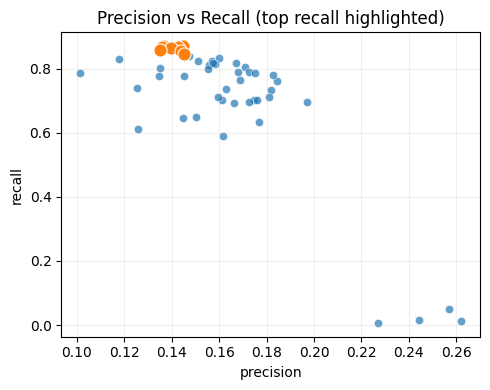

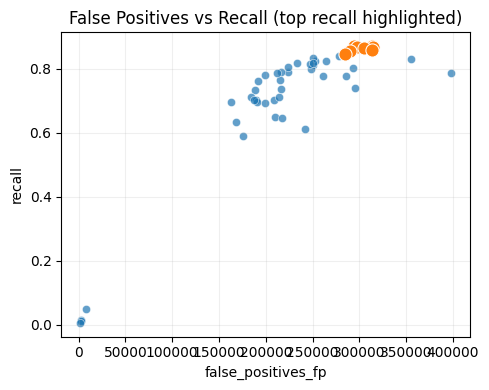

Saved figures to: results/final_figures


In [156]:
df = joined_clean  # authoritative, engineered

OUTDIR = "results/final_figures"
os.makedirs(OUTDIR, exist_ok=True)

params = ["alpha", "sigma", "gamma", "low_perc", "high_perc"]

# ---------------------------
# Fig 01 — Recall vs params (small multiples + quadratic fit)
# ---------------------------
ymin, ymax = df["recall"].min(), df["recall"].max()

fig, axes = plt.subplots(1, len(params), figsize=(4*len(params), 3), sharey=True, constrained_layout=True)
for ax, p in zip(axes, params):
    x = df[p].values
    y = df["recall"].values

    ax.scatter(x, y, s=35, alpha=0.8)

    xs = np.linspace(x.min(), x.max(), 200)
    coeffs = np.polyfit(x, y, deg=2)
    ys = np.polyval(coeffs, xs)
    ax.plot(xs, ys, linewidth=2)

    ax.set_title(f"Recall vs {p}")
    ax.set_xlabel(p)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.25)

axes[0].set_ylabel("recall")
path = os.path.join(OUTDIR, "fig01_recall_vs_params.png")
fig.savefig(path, dpi=200)
plt.show()


# ---------------------------
# Fig 02 — Interaction: gamma × alpha (median recall heatmap)
# ---------------------------
piv = df.pivot_table(index="gamma", columns="alpha", values="recall", aggfunc="median")
plt.figure(figsize=(7, 5))
sns.heatmap(piv, annot=False)
plt.title("Median Recall Surface: gamma × alpha")
plt.xlabel("alpha (sharpen strength)")
plt.ylabel("gamma (brightness)")
plt.tight_layout()
path = os.path.join(OUTDIR, "fig02_heatmap_gamma_alpha.png")
plt.savefig(path, dpi=200)
plt.show()


# ---------------------------
# Fig 03 — Interaction slice: gamma vs recall colored by alpha quartile
# ---------------------------
alpha_bins = pd.qcut(df["alpha"], q=4, duplicates="drop")

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="gamma", y="recall", hue=alpha_bins, s=40, alpha=0.85)
plt.title("Gamma vs Recall (colored by alpha quartile)")
plt.xlabel("gamma (brightness)")
plt.ylabel("recall")
plt.grid(True, alpha=0.2)
plt.tight_layout()
path = os.path.join(OUTDIR, "fig03_gamma_vs_recall_by_alpha_bin.png")
plt.savefig(path, dpi=200)
plt.show()


# ---------------------------
# Fig 04 — Precision vs Recall (highlight top recall)
# ---------------------------
topk = 8
top = df.nlargest(topk, "recall")

plt.figure(figsize=(5, 4))
sns.scatterplot(data=df, x="precision", y="recall", s=35, alpha=0.7)
sns.scatterplot(data=top, x="precision", y="recall", s=90)
plt.title("Precision vs Recall (top recall highlighted)")
plt.xlabel("precision")
plt.ylabel("recall")
plt.grid(True, alpha=0.2)
plt.tight_layout()
path = os.path.join(OUTDIR, "fig04_precision_vs_recall.png")
plt.savefig(path, dpi=200)
plt.show()


# ---------------------------
# Fig 05 — False Positives vs Recall (highlight top recall)
# ---------------------------
plt.figure(figsize=(5, 4))
sns.scatterplot(data=df, x="false_positives_fp", y="recall", s=35, alpha=0.7)
sns.scatterplot(data=top, x="false_positives_fp", y="recall", s=90)
plt.title("False Positives vs Recall (top recall highlighted)")
plt.xlabel("false_positives_fp")
plt.ylabel("recall")
plt.grid(True, alpha=0.2)
plt.tight_layout()
path = os.path.join(OUTDIR, "fig05_fp_vs_recall.png")
plt.savefig(path, dpi=200)
plt.show()


print("Saved figures to:", OUTDIR)


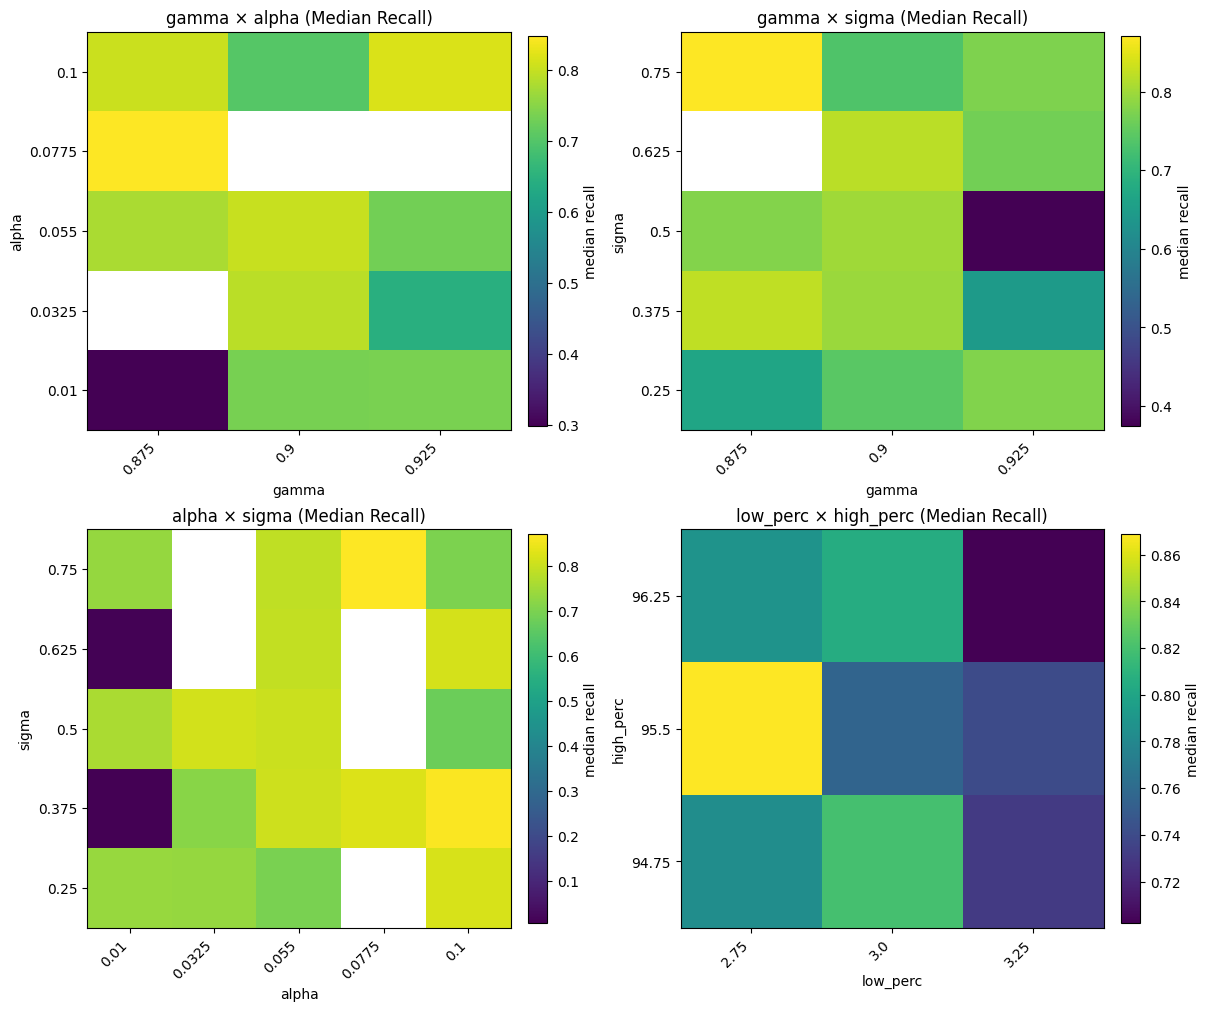

Saved: results/final_figures/fig06_interaction_heatmaps_grid.png


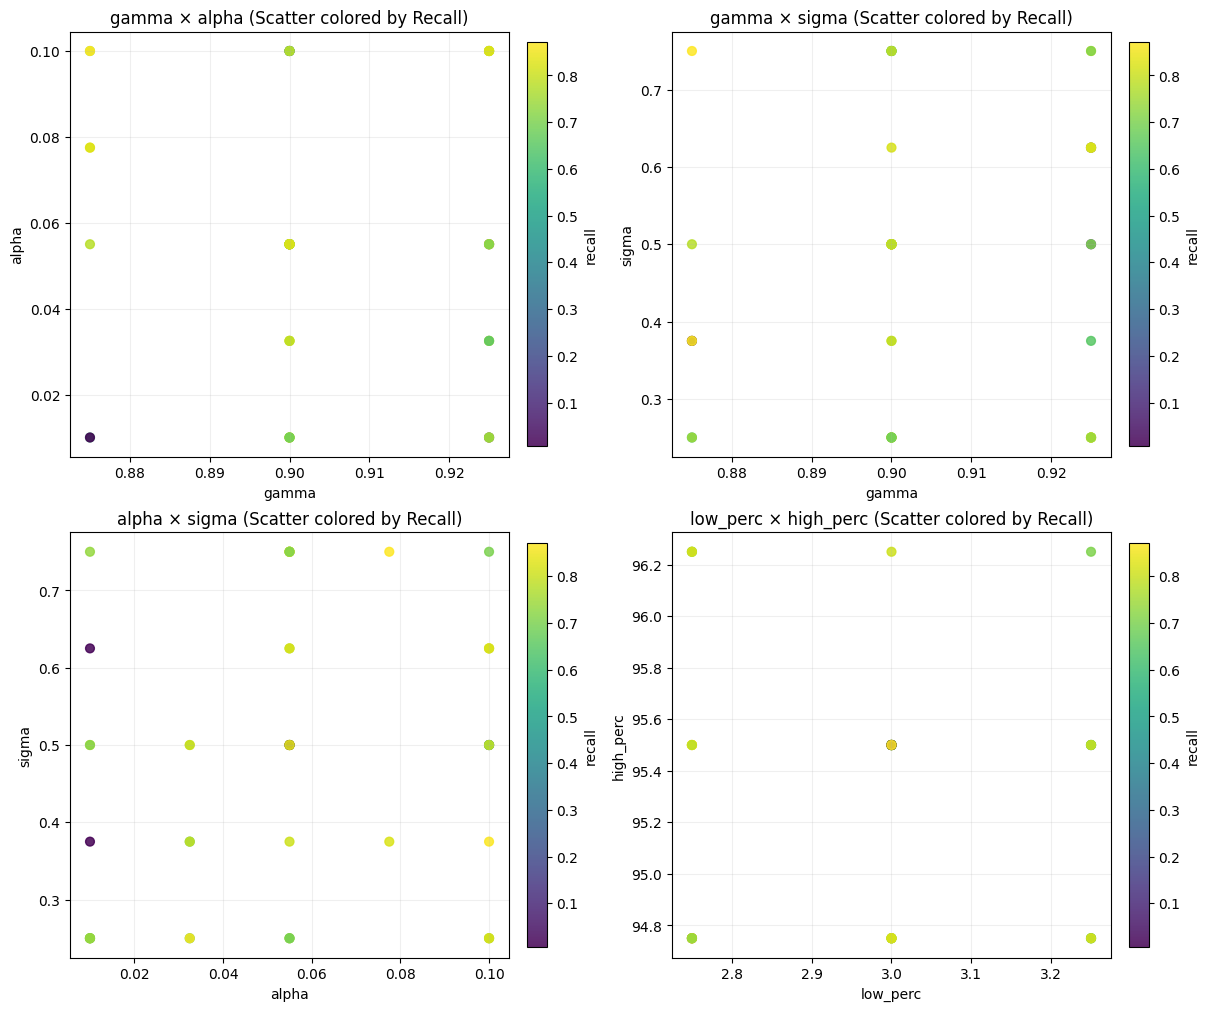

Saved: results/final_figures/fig07_interaction_scatter_support_grid.png


In [ ]:
df = joined_clean  # 

OUTDIR = "results/final_figures"
os.makedirs(OUTDIR, exist_ok=True)

pairs = [
    ("gamma", "alpha", "gamma × alpha (Median Recall)"),
    ("gamma", "sigma", "gamma × sigma (Median Recall)"),
    ("alpha", "sigma", "alpha × sigma (Median Recall)"),
    ("low_perc", "high_perc", "low_perc × high_perc (Median Recall)"),
]

# ---------------------------
# FIG A: HEATMAP GRID (2x2)
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
axes = axes.ravel()

for ax, (x, y, title) in zip(axes, pairs):
    piv = df.pivot_table(index=y, columns=x, values="recall", aggfunc="median")

    im = ax.imshow(piv.values, origin="lower", aspect="auto")
    ax.set_title(title)

    # ticks show actual parameter values
    ax.set_xticks(np.arange(piv.shape[1]))
    ax.set_xticklabels([str(v) for v in piv.columns], rotation=45, ha="right")
    ax.set_yticks(np.arange(piv.shape[0]))
    ax.set_yticklabels([str(v) for v in piv.index])

    ax.set_xlabel(x)
    ax.set_ylabel(y)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("median recall")

heat_path = os.path.join(OUTDIR, "fig06_interaction_heatmaps_grid.png")
fig.savefig(heat_path, dpi=200)
plt.show()

print("Saved:", heat_path)


# ---------------------------
# FIG B: SCATTER SUPPORT GRID (2x2)
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
axes = axes.ravel()

vmin, vmax = df["recall"].min(), df["recall"].max()

for ax, (x, y, title) in zip(axes, pairs):
    sc = ax.scatter(df[x].values, df[y].values, c=df["recall"].values, s=40,
                    alpha=0.85, vmin=vmin, vmax=vmax)
    ax.set_title(title.replace("(Median Recall)", "(Scatter colored by Recall)"))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid(True, alpha=0.2)

    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("recall")

scat_path = os.path.join(OUTDIR, "fig07_interaction_scatter_support_grid.png")
fig.savefig(scat_path, dpi=200)
plt.show()

print("Saved:", scat_path)


# END OF FILE

# JUNKYARD

SCRATCHPAD

In [ ]:
'''
########NOTHING ABOVE THIS LINE##################

import pandas as pd

df = pd.read_csv("relative/path/to/file.csv")


# same directory as the script / notebook
df = pd.read_csv("file.csv")

# one level up
df = pd.read_csv("../file.csv")

# subdirectory
df = pd.read_csv("data/file.csv")


from pathlib import Path
import pandas as pd

BASE_DIR = Path(__file__).resolve().parent
df = pd.read_csv(BASE_DIR / "data" / "file.csv")


"GC_released/tree_point_prediction/"cve_experiment_logs/G09_EE_20260114_083242/cve_run_summary.csv"







































'''